<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# SINGULAR VALUE DECOMPOSITION (SVD)

>## "A singularly valuable decomposition" 
>--Dan Kalman 

>## "Singular Value Decomposition. Love it, learn it."
>--Michael Basial

>## "SVD? Magic, simply magic."
>--John Doherty

As we've said, the key to representative environmental models is allowing high levels of flexibility through a highly parameterized approach.  But this makes our parameter estimation problem illposed and underdetermined, which means our solution is nonunique even if we overcome problems of increased instability and longer runtimes.  Here we use a "regularized inversion" approach to overcome these problems.  Regularization is anything that makes an intractable problem solvable; for example, using a small number of zones (not highly-parameterized) is a way to regularize an illposed problem.  Regularization as we use here can be grouped into two broad categories: 1) adding soft-knowledge to the problem (Tikhonov regularization) and 2) mathematically reducing the dimensionality of the model (subspace regularization via singular value decomposition (SVD)). In practice we typically use a combination ("hybrid") of these two approaches. 

It is worth expounding on this difference in regularization approaches. In contrast to Tikhonov regularization, which adds information to the calibration process to achieve numerical stability, subspace methods achieve stability through subtracting parameters, and/or parameter combinations, from the calibration process (making a "subspace" of the full parameter space). Now the calibration process is no longer required to estimate either individual parameters or combinations of correlated parameters that are inestimable given the calibration dataset we have. What combinations are estimable are automatically determined through SVD. 

The effort needed to take advantage of these regularization strategies is also appreciably different, where SVD is relatively easily brought to bear and becomes "set it and forget it". Moreover, when SVD is used the parameter estimation problem always becomes __unconditionally stable__! Neither of these is true in all cases when adding soft knowledge using Tikhonov regularization. 

In summary, SVD benefits apply to all models so it is worth widely invoking when using PEST and PEST++.  SVD involves few parameter estimation inputs, default values work for a large range of problems, and it addresses instability for all problems. Can you catch that we can't overemphasize the importance of SVD to parameter estimation?  "Magic" indeed! 


### In this and the next notebooks we'll get under the hood of SVD and see what it does.  A high-level understanding is not needed to take advantage of the power of SVD for your typical calibration parameter estimation problem ("set it and forget it").  BUT in addition to the glow of knowledge that they impart, these SVD concepts will cascade into understanding other tools such as Parameter Identifiability, calculation of uncertainty, and null-space Monte Carlo.  

In [1]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
import pestools as pt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='./pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];


setting random seed


In [2]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')

In [3]:
inpst.pestpp_options['n_iter_super'] = 100
inpst.pestpp_options['max_n_super'] = 2

inpst.pestpp_options

{'forecasts': 'rivflux_fore,travel_time,fr03c16,fr04c9',
 'max_n_super': 2,
 'n_iter_base': '-1',
 'n_iter_super': 100,
 'super_eigthres': '1.0e-8'}

In [4]:
inpst.write('freyberg_sing2.pst')

## Linear Algebra is the foundation of much of our maths and modeling. At the basis of this is matrices, which are containing vector information like spatial array of properties, mappings from one set of properties to another, the variability of properties.

## Another example of a matrix is just a photograph. It turns out, much of the information contained in a matrix is redundant. If we think of the columns of a matrix as vectors, they are orthogonal but maybe aren't quite the right basis for the infromation. What if we could find another basis, where we rotate to a more suitable set of orthogonal basis vectors and maybe even stretch them?

## Any matrix can be decomposed into 3 matrices
## <center> $\mathbf{M}=\mathbf{U}\mathbf{S}\mathbf{V}^T$ </center>

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

# Let's evaluate how this works by exploring the information content in an image

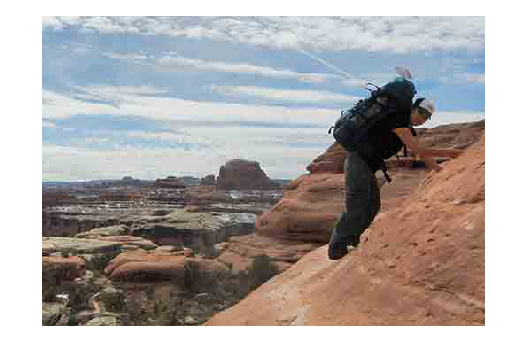

In [7]:
photo = Image.open('clands.jpg')
plt.imshow(photo, interpolation='nearest')
plt.axis('off');

## Convert to grayscale

### By converting to grayscale, what we are left with is a matrix of information where each pixel (e.g. a cell in rows/columns of the matrix) has a value between 0 and 255 indicating intensity. This is then just a matrix with information in it.

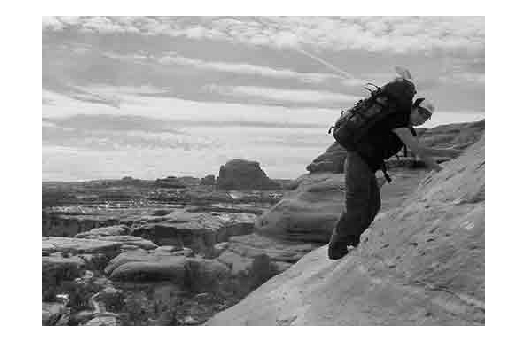

In [8]:
photogray = np.array(photo.convert('L'))
plt.imshow(photogray, interpolation='nearest', cmap='gray')
plt.axis('off');

## We can treat this like any matrix and perform SVD

In [9]:
U, sigma, V = np.linalg.svd(photogray)

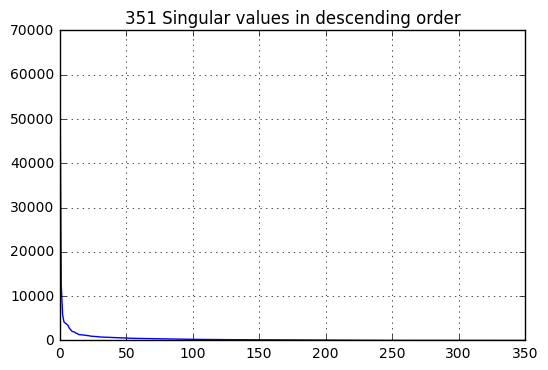

In [10]:
plt.plot(sigma)
plt.grid('on')
plt.title('{0} Singular values in descending order'.format(len(sigma)));

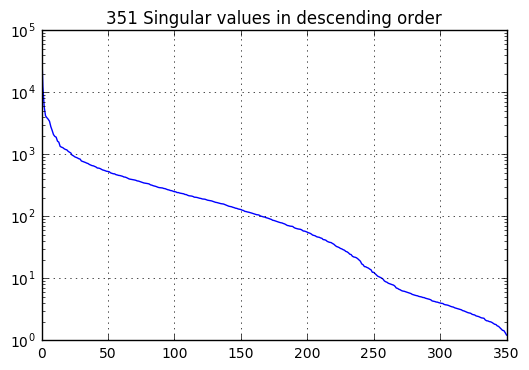

In [11]:
plt.plot(sigma)
plt.grid('on')
plt.title('{0} Singular values in descending order'.format(len(sigma)));
plt.yscale('log');

## Let's make a little function for using a subset of singular values to reconstitute the image

In [12]:
def recon_image(U,sigma,V,numsing=1, photo=None, printflag=False):
    reconimg = np.dot(np.dot(U[:,:numsing], np.diag(sigma[:numsing])),V[:numsing,:])

    if printflag==True:
        fig,ax = plt.subplots(ncols=2, figsize=(8,8))
        ax[0].imshow(photo, interpolation='nearest', cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original')
        ax[1].imshow(reconimg, interpolation='nearest', cmap='gray')
        ax[1].axis('off')
        ss = 's'
        if numsing==1:
            ss = ''
        ax[1].set_title('Using {0} singular value{1}'.format(numsing,ss))
        plt.tight_layout()
        plt.savefig(os.path.join('pngs','svd_{0}.png'.format(numsing)), bbox_inches='tight', pad_inches=0.2)
        plt.close()
    return reconimg


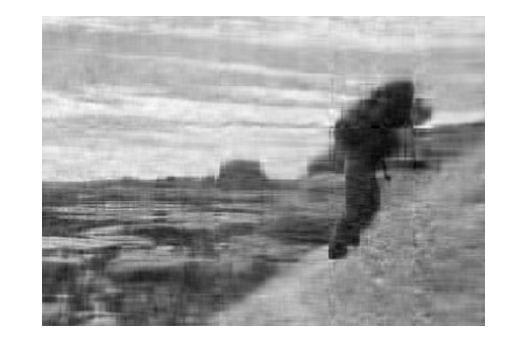

In [20]:
rec=recon_image(U,sigma,V,20)
plt.imshow(rec,cmap='gray')
plt.axis('off');

## We can also make images sequentially adding singular values

Note - this requires `ffmpeg` to be installed

Also note the two flags set to `False` for now to be sure that we only remake them if we want to

In [21]:
import platform
if 'window' in platform.platform().lower():
    pref = ''
else:
    pref = './'
make_images=False
make_movie=False

if make_images:
    if not os.path.exists('pngs'):
        os.mkdir('pngs')
    for i in range(len(sigma)):
        print(i)
        recon_image(U, sigma, V, i+1,photogray, True)

if make_movie:
    if os.path.exists('svdmovie.mp4'):
        os.remove('svdmovie.mp4')
    runstr='{0}ffmpeg -f image2 -r 10  -i pngs/svd_%d.png -vcodec libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" svdmovie.mp4'.format(pref)
    os.system(runstr)

# Fun times, but what does this have to do with modeling?

In [22]:
import pyemu

### Let's load up a Jacobian Matrix

In [23]:
injac = pyemu.Jco.from_binary(os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints','freyberg_pp.jcb'))

In [24]:
injac.df().head()

,rch1,hkpp1,hkpp2,hkpp3,hkpp4,hkpp5,hkpp6,hkpp7,hkpp8,hkpp9,...,hkpp61,hkpp62,hkpp63,hkpp64,hkpp65,hkpp66,hkpp67,hkpp68,hkpp69,hkpp70
cr03c16,1.328281,0.000000,0.002314,0.006942,0.055538,0.134217,-0.030083,0.000000,0.000000,-0.004628,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
cr03c10,5.947183,0.041653,0.106448,0.092563,-0.976541,-0.541494,-0.016199,0.048596,0.013884,-0.224466,...,0.0,-0.006942,-0.006942,-0.004628,-0.002314,0.0,0.000000,-0.002314,-0.002314,0.000000
cr04c9,6.942237,0.030083,0.076365,-0.168928,-0.971913,-0.441989,-0.016199,0.064794,0.101819,-0.347112,...,0.0,-0.009256,-0.009256,-0.006942,-0.002314,0.0,-0.002314,-0.002314,-0.004628,-0.002314
cr10c2,15.638545,-0.289260,-0.555379,-0.654884,-0.490585,-0.180498,-0.006942,-0.634058,-1.161668,-0.782159,...,0.0,-0.057852,-0.053224,-0.037025,-0.013884,0.0,-0.009256,-0.011570,-0.016199,-0.006942
cr14c11,2.732927,-0.002314,-0.013884,-0.034711,-0.062480,-0.034711,0.000000,0.006942,0.030083,0.027769,...,0.0,-0.006942,-0.006942,-0.004628,-0.002314,0.0,0.000000,0.000000,-0.002314,0.000000


In [25]:
inpst = pyemu.Pst(os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints','freyberg_pp.pst'))

In [26]:
Q = inpst.observation_data.weight.as_matrix()

In [27]:
Q = np.diag(Q)
Q.shape

(33, 33)

In [28]:
X = injac.df().as_matrix()

/Users/mnfienen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/mnfienen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


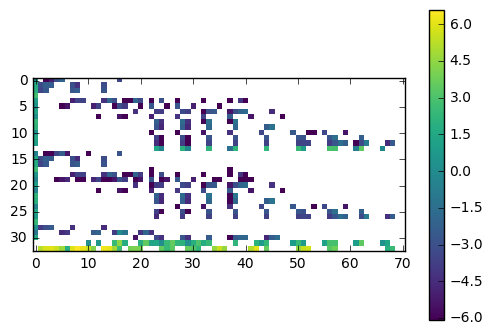

In [29]:
plt.imshow(np.log(X), interpolation='nearest', cmap='viridis')
plt.colorbar()

## We can form up the normal equations matrix (including weights) and take a look at it

This matrix is $\mathbf{X}^T\mathbf{Q}\mathbf{X}$

In [30]:
XtQX=X.T.dot(Q).dot(X)

In [31]:
U, sigma, V = np.linalg.svd(XtQX)

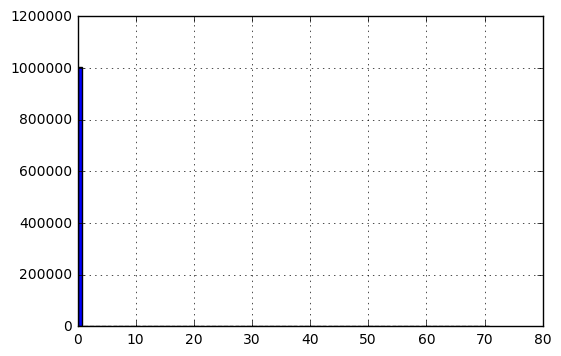

In [32]:
plt.bar(range(len(sigma)),sigma)
plt.grid('on')

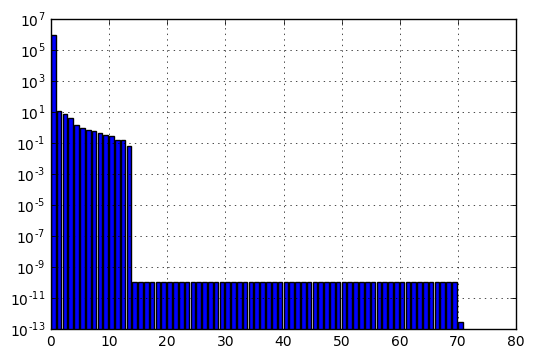

In [33]:
plt.bar(range(len(sigma)),sigma)
plt.yscale('log')
plt.grid('on')

/Users/mnfienen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/mnfienen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


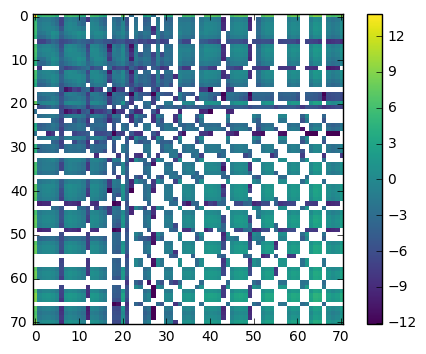

In [34]:
plt.imshow(np.log(XtQX), interpolation='nearest', cmap='viridis')
plt.colorbar()

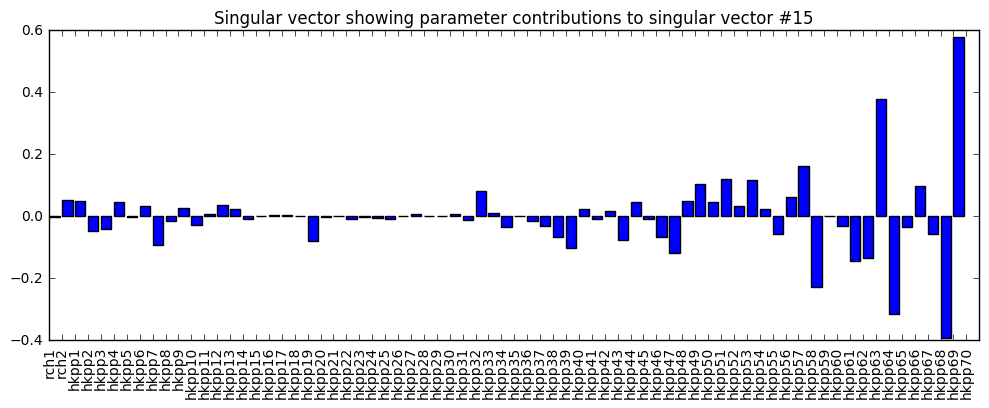

In [42]:
# select which singular vector you want to plot
SV=15

plt.figure(figsize=(12,4))
plt.bar(list(range(U.shape[0])),U[:,SV-1])
#plt.yscale('log')
plt.xlim([0,72])
plt.xticks(list(range(72)))
plt.title('Singular vector showing parameter contributions to singular vector #{0}'.format(SV))
plt.gca().set_xticklabels(inpst.parameter_data['parnme'], rotation=90);